In [121]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score

import numpy as np
from sklearn.utils import class_weight

from sklearn import metrics

In [122]:
ds=pd.read_csv('ahc.csv')
ds.head(5)

,1,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,symptom
0,0.385714,-0.730334,-0.139520,0.885217,0.185512,-0.092579,1.675729,-0.686223,0.531079,1.260273,...,0.310443,0.685676,0.743884,-1.707476,0.409856,0.234790,0.124626,-0.304451,-0.098937,1
1,-1.139784,0.202991,-0.172729,2.288758,0.832926,-1.270105,-0.541457,-0.299268,-0.662836,-1.111758,...,0.347890,0.022021,-0.588785,-2.409142,-0.092867,0.687847,-1.272507,0.852925,-0.070433,1
2,0.301588,-1.216219,-0.320328,1.682189,1.250116,-1.544504,-0.439693,0.573244,-0.466864,0.410886,...,0.699880,0.722700,-0.565397,-1.177416,1.832512,-1.763520,1.174136,-0.110950,-0.721374,1
3,0.610831,-0.224714,3.514447,0.002929,-2.178927,1.008115,-0.221103,0.152922,0.782051,-0.069084,...,0.100465,1.928904,-0.030931,0.060462,-1.101277,0.496262,-0.477511,1.070145,0.226384,1
4,0.683467,0.778225,-0.244681,-0.104264,-0.153930,1.351049,0.544877,1.948468,-0.672722,-0.002173,...,0.068522,0.431119,1.112156,0.008301,-0.151477,1.208057,-1.728618,-0.297925,-2.181558,1


In [3]:
ds['symptom'].value_counts()

0    2176
1     692
Name: symptom, dtype: int64

In [4]:
#Balancing dataset
ds_adhd=ds[ds['symptom']==1]
ds_health=ds[ds['symptom']==0]
ds_health_downsampled=ds_health.sample(ds_adhd.shape[0])  # shape:输出是一元组 (行数,列数)
ds_balanced=pd.concat([ds_health_downsampled,ds_adhd]) # concat默认行(上下)拼接即axis=0
ds_balanced['symptom'].value_counts()

0    692
1    692
Name: symptom, dtype: int64

In [5]:
ds_balanced.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,symptom
1693,-0.731533,-0.519225,2.264789,-0.610664,-0.939487,-2.682708,-0.065137,-0.673681,-0.682521,-0.483995,...,-1.704101,-0.270146,0.305531,-0.780711,0.042887,0.941008,-0.651509,-0.582192,1.530018,0
1588,-1.357142,-1.141606,2.961529,0.602351,-1.355843,-0.540607,0.750161,-1.382257,0.676223,-0.638533,...,0.336957,0.094430,0.855493,0.034459,-1.045637,0.046400,-0.066412,1.535470,0.370893,0
242,0.120954,0.512753,0.162198,1.623334,-0.034401,0.019096,0.858374,-0.783777,-0.100561,-0.604763,...,-0.253814,0.163235,-0.540267,0.374053,-1.587961,-0.106409,-0.167028,0.891006,-0.252242,1
2708,0.599745,0.941052,-0.014862,0.541473,0.923372,-1.408475,0.070643,1.380120,-0.184097,-1.151705,...,0.104272,1.566259,0.509633,2.236204,-0.614448,-1.588986,-0.518222,1.552253,-0.083523,0
1907,-0.281279,-0.381536,-0.428636,0.408470,-0.834166,0.565728,-1.350290,0.337692,-0.706282,-0.867092,...,-0.471015,0.850780,-0.472048,1.667271,0.279797,0.648467,0.006986,0.352835,-0.471623,0


In [6]:
tr = ds_balanced.columns[:-1]
#Splitting labeled dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds_balanced[tr],ds_balanced['symptom'], stratify=ds_balanced['symptom'])

In [6]:
tr = ds.columns[:-1]
#Splitting labeled dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds[tr],ds['symptom'], stratify=ds['symptom'])

In [123]:
#下面情况都未欠采样/过采样, 实验发现未采样效果更好
#没class_weight/sample_weight时, 最高为train:0.8038/val_accuracy:0.7615(参数应该为512units, 2layers, batch_size=256)
#有class_weight时, 1024units, 3layers, batch_size=256时, 大概val_accuracy最高运行某次为0.7592
# model = keras.Sequential([
#     layers.BatchNormalization(input_shape=[50]),
#     layers.Dense(1024, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(rate=0.3),
#     layers.Dense(1024, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(rate=0.3),
#     layers.Dense(1024, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(rate=0.3),
#     layers.Dense(1, activation='sigmoid'),
# ])

#有class_weight时, 512units, 2layers, batch_size=256时, 大概val_accuracy次高运行某次为0.7487
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[50]),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [124]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [125]:
#Model compiling
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS) #when not using class_weight or sample_weight in model.fit()
             #weighted_metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [57]:
#class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train)

total = 2868
pos = 692
neg = 2176
print(f'total: {total}', f'neg: {neg}', f'pos: {pos}')
weight_for_0 = (1 / neg) *(total)/2.0
weight_for_1 = (1 / pos) *(total)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

total: 2868 neg: 2176 pos: 692
Weight for class 0: 0.66
Weight for class 1: 2.07


In [112]:
#(class_weight = 'balanced', classes= np.unique(y_train), y= y_train) 括号内参数名需写完整, 不能省略如只写'balanced'
#此方法返回结果是类weights的array不是dictionary, 但model.fit中的class_weight参数格式是dictionary,所以需转换
class_weight_vect = class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train)
class_weights = {0 : class_weight_vect[0], 1 : class_weight_vect[1]}
class_weights

{0: 0.6591039632395175, 1: 2.07129963898917}

In [126]:
#Fitting the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=256, epochs=1000, callbacks=[early_stopping])
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=256, epochs=1000, callbacks=[early_stopping], class_weight = class_weights)
#sample_weight即返回结果是样本权重的array
'''class_weight.compute_sample_weight的属性/参数class_weight 若值为'balanced', 则to use the values of y to automatically adjust 
weights inversely proportional to class frequencies in the input data: 
n_samples / (n_classes * np.bincount(y))'''
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=256, epochs=1000, callbacks=[early_stopping], sample_weight = class_weight.compute_sample_weight('balanced', y_train))

Epoch 1/1000
9/9 [==============================] - 4s 152ms/step - loss: 0.9132 - accuracy: 0.5281 - precision: 0.2540 - recall: 0.4928 - val_loss: 0.6317 - val_accuracy: 0.7260 - val_precision: 0.2889 - val_recall: 0.0942
Epoch 2/1000
9/9 [==============================] - 0s 50ms/step - loss: 0.7082 - accuracy: 0.6253 - precision: 0.3269 - recall: 0.5217 - val_loss: 0.6043 - val_accuracy: 0.7574 - val_precision: 0.4444 - val_recall: 0.0290
Epoch 3/1000
9/9 [==============================] - 0s 51ms/step - loss: 0.6042 - accuracy: 0.6832 - precision: 0.3881 - recall: 0.5415 - val_loss: 0.5845 - val_accuracy: 0.7522 - val_precision: 0.3333 - val_recall: 0.0290
Epoch 4/1000
9/9 [==============================] - 1s 61ms/step - loss: 0.5352 - accuracy: 0.7298 - precision: 0.4540 - recall: 0.5884 - val_loss: 0.5629 - val_accuracy: 0.7609 - val_precision: 1.0000 - val_recall: 0.0072
Epoch 5/1000
9/9 [==============================] - 0s 52ms/step - loss: 0.4783 - accuracy: 0.7778 - precis

"class_weight.compute_sample_weight的属性/参数class_weight 若值为'balanced', 则to use the values of y to automatically adjust \nweights inversely proportional to class frequencies in the input data: \nn_samples / (n_classes * np.bincount(y))"

<AxesSubplot:title={'center':'Accuracy'}>

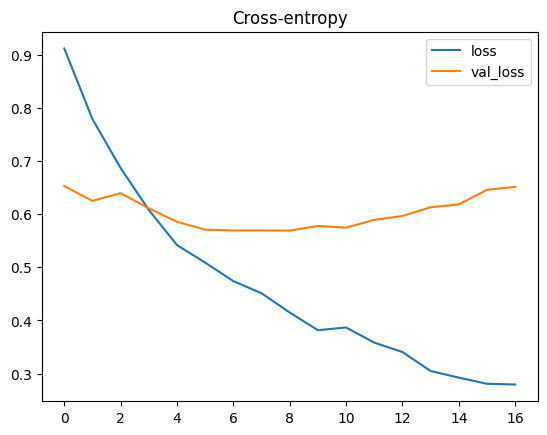

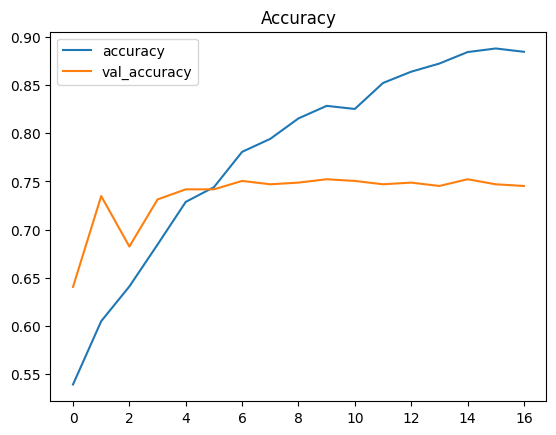

In [114]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [69]:
#pred = model.predict(X_test)
#print(mean_absolute_error(y_test, pred))

#第一种 model.predict()只输入X, 返回值是预测的y值
# predclass = (model.predict(X_test) > 0.5).astype('int64')
# print(accuracy_score(y_test, predclass))

#第二种model.evaluate()输入X，y 返回值是Scalar test loss (if the model has a single output and no metrics) or list of scalars (if the model has multiple outputs and/or metrics)
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 6ms/step - loss: 0.5578 - accuracy: 0.7587 - precision: 0.5000 - recall: 0.0116  


[0.5577552914619446, 0.758716881275177, 0.5, 0.011560693383216858]

In [22]:
 ds.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', 'symptom'],
      dtype='object')

In [48]:
#cross_validation: StratifiedKFold, model.evaluate(), tf.keras.metrics 
tr = ds.columns[:-1]
# define 5 or 10-fold cross validation test harness
'''This cross-validation object is a variation of KFold that returns stratified folds. 
The folds are made by preserving the percentage of samples for each class.'''
kfold = StratifiedKFold(n_splits=5, shuffle=False)
'''当10-fold时，无class_weight/sample_weight,
parameters:1024(128/256)units 3(2/3)layers batch_size256(64/128)时 val_acc:0.7605(0.7608/0.7608)+/-0.0023(0.0024/0.0070)效果最好.
当5-fold时，有class_weight,
parameters:1024units 3layers batch_size256时 val_acc:0.7594+/-0.0028效果最好;
或有sample_weight,
parameters:1024units 3layers batch_size256时 val_acc:0.7591+/-0.0021效果最好也不错.'''
cvscores = []
for train, test in kfold.split(ds[tr],ds.symptom):
    X_train = ds[tr].loc[train]
    y_train = ds.symptom.loc[train]
       
        
    X_test = ds[tr].loc[test]
    y_test = ds.symptom.loc[test]
    
    # create model
    model = keras.Sequential([
    layers.BatchNormalization(input_shape=[50]),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid'),
    ])
    
    early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
    )
    
    # Compile model
    METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name='recall')
    ]
    
    class_weight_vect = class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train)
    class_weights = {0 : class_weight_vect[0], 1 : class_weight_vect[1]}
    
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
    model.compile(loss='binary_crossentropy', optimizer='adam', weighted_metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
    # Fit the model
    #history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=256, epochs=1000, callbacks=[early_stopping])
    #class_weight效果不好val_acc大概0.6
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=512, epochs=1000, callbacks=[early_stopping], class_weight = class_weights)
    #history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=256, epochs=1000, callbacks=[early_stopping], sample_weight = class_weight.compute_sample_weight('balanced', y_train))
    # evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.4f" % (model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
#     print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#     cvscores.append(scores[1]*100)
 
#print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("%.4f (+/- %.4f)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/1000
5/5 [==============================] - 6s 417ms/step - loss: 1.0349 - accuracy: 0.5284 - val_loss: 0.6339 - val_accuracy: 0.7195
Epoch 2/1000
5/5 [==============================] - 1s 280ms/step - loss: 0.8673 - accuracy: 0.6072 - val_loss: 0.6728 - val_accuracy: 0.6132
Epoch 3/1000
5/5 [==============================] - 2s 313ms/step - loss: 0.7530 - accuracy: 0.6535 - val_loss: 0.6467 - val_accuracy: 0.6603
Epoch 4/1000
5/5 [==============================] - 1s 280ms/step - loss: 0.6299 - accuracy: 0.7114 - val_loss: 0.5844 - val_accuracy: 0.7474
Epoch 5/1000
5/5 [==============================] - 1s 274ms/step - loss: 0.5167 - accuracy: 0.7689 - val_loss: 0.5924 - val_accuracy: 0.7317
Epoch 6/1000
5/5 [==============================] - 1s 290ms/step - loss: 0.4653 - accuracy: 0.7872 - val_loss: 0.5608 - val_accuracy: 0.7578
Epoch 7/1000
5/5 [==============================] - 1s 280ms/step - loss: 0.4067 - accuracy: 0.8280 - val_loss: 0.5527 - val_accuracy: 0.7544
Epoch 

<AxesSubplot:title={'center':'Accuracy'}>

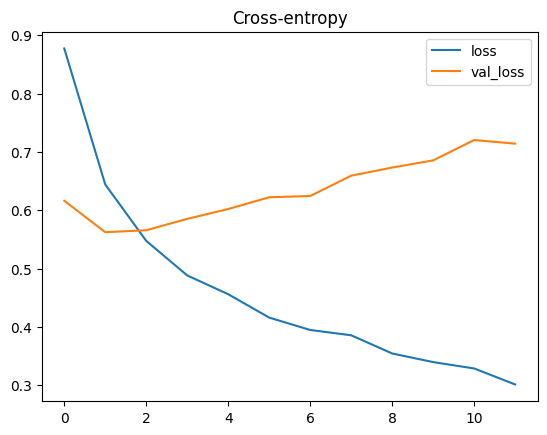

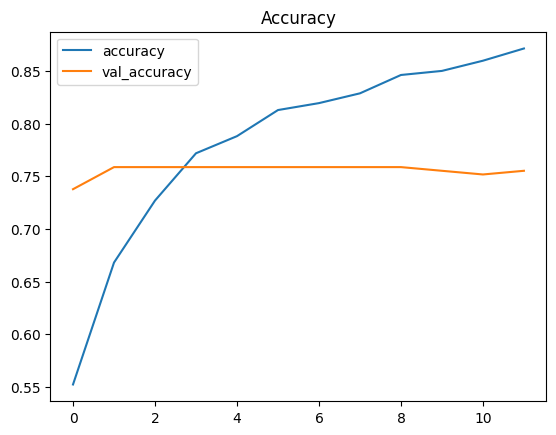

In [77]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")